In [1]:
import sys
sys.path.append('../../../')



import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scripts.utils import  rep_path, set_mpl, path2plots
import pandas as pd
set_mpl()


sigmas_clu = np.array([0.3, 0.2, 0.1,   0.07, 0.05,
                       0.03, 0.02, 0.015, 0.01, 0.005])
f_fails_clu = np.array([0.01, 0.02, 0.05,  0.1, 0.2])


sigmas_agn = np.array([0.3, 0.2, 0.1,   0.07, 0.05,
                       0.03, 0.02, 0.015])
f_fails_agn = np.array([0.01, 0.02, 0.05,  0.1, 0.2])




%matplotlib inline
savepath = rep_path + 'forecast/Fisher_matrices/impact-photoz-bao/data/'


set palette to mallsoft, shuffle=False
set matplotlib rc
set palette to mallsoft, shuffle=False
set matplotlib rc


In [2]:
def load_fisher_sigma0_f_fail(sigma_0, f_fail,):
    setname_clu = f'Clusters_{sigma_0}_{f_fail}'
    fname_clu = savepath + f'{setname_clu}_bao_sign.npz'

    setname_agn = f'AGN_{sigma_0}_{f_fail}'
    fname_agn = savepath + f'{setname_agn}_bao_sign.npz'

    bao_sign = []
    for fname in [fname_clu, fname_agn]:
        try:
            arr = np.load(fname, allow_pickle=True)
            bao_sign.append(np.sqrt(arr['bao_sign']))
        except:
            print(f'{fname} not found')
            bao_sign.append(None)
    return bao_sign



In [3]:
df_bao = pd.DataFrame(columns=['sigma_0', 'f_fail', 'bao_sign_clu', 'bao_sign_agn'])
for sigma_0 in sigmas_all:
    for f_fail in f_fails_all:
        bao_sign = load_fisher_sigma0_f_fail(sigma_0, f_fail)
        df_bao = df_bao.append({'sigma_0': sigma_0, 'f_fail': f_fail, 'bao_sign_clu': bao_sign[0], 'bao_sign_agn': bao_sign[1]}, ignore_index=True)
        #print(f'====== {sigma_0=} {f_fail=}, index = {idx} ====')

/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.01_0.01_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.01_0.02_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.01_0.05_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.01_0.1_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.01_0.2_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.005_0.01_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.005_0.02_bao_sign.npz not found
/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao/data/AGN_0.005_0.05_bao_sign.npz not found

In [4]:
s_all, f_all = np.meshgrid(sigmas_all, f_fails_all)
s_agn, f_agn = np.meshgrid(sigmas_agn, f_fails_all)

def bao_significance(si,fi, type = 'AGN', factor = 1):
    #to compare with huetsi2014 use factor np.sqrt(1/(0.658) (to make f_sky = 1)
    if type == 'AGN':
        return df_bao.query('(f_fail == @fi) & (sigma_0 == @si)')['bao_sign_agn'].values[0]*factor
    elif type == 'Clusters':
        return df_bao.query('(f_fail == @fi) & (sigma_0 == @si)')['bao_sign_clu'].values[0]*factor
        


In [5]:
set_mpl()


def log_interp2d(xx, yy, zz,  kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    logz = np.log10(zz)
    lin_interp = interp2d(logx, logy, logz, kind=kind)
    def log_interp(xx, yy): return np.power(
        10.0, lin_interp(np.log10(xx), np.log10(yy)))
    return log_interp


def plot_results(type='AGN', interp='cubic', cmap='GnBu', fsky=0.658):
    vbao_significance = np.vectorize(bao_significance)
    if type == 'AGN':
        s = s_agn
        f = f_agn
        sigmas = sigmas_agn
        f_fails = f_fails_all
    else:
        s = s_all
        f = f_all
        sigmas = sigmas_all
        f_fails = f_fails_all

    sign = vbao_significance(s, f,  type=type, factor=np.sqrt(fsky/0.658))
    fig1 = plt.figure(figsize=(15, 10))
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.5)
    rows, cols = 2, 5
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax = plt.subplot2grid((rows, cols), (0, 0), rowspan=2, colspan=3)
    ax_slice1 = plt.subplot2grid((rows, cols), (0, 3), rowspan=1, colspan=2)
    ax_slice2 = plt.subplot2grid((rows, cols), (1, 3), rowspan=1, colspan=2)

    #interp_err = interp2d(s, f, sign, kind=interp)
    interp_err = log_interp2d(s, f, sign, kind=interp)
    xnew = np.geomspace(np.min(sigmas), np.max(sigmas), 100)
    ynew = np.geomspace(np.min(f_fails), np.max(f_fails), 100)
    sign_int = interp_err(xnew, ynew)
    s_int, f_int = np.meshgrid(xnew, ynew)
    im2 = ax.pcolormesh(s_int, f_int, sign_int, cmap=cmap)
    cp = ax.contour(s_int, f_int, sign_int, [2, 3, 4, 5, 6, 7, 8, 9], colors=[
                    'w'], linestyles='-.', linewidths=1, alpha=0.7)
    ax.clabel(cp, inline=1, fontsize=15, fmt='%1.2f')
    cbar = fig1.colorbar(im2, ax=ax)
    cbar.set_label(r'$S/N$', rotation=90, labelpad=20)
    ax.scatter(s, f, marker='o', c=sign, s=40, label='sampled', cmap=cmap)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\sigma_0$')
    ax.set_ylabel(r'$f_{\rm fail}$')
    ax.set_title(rf"{type}, $f_{{\rm sky}}=${fsky}")
    ax.set_xlim(0.9*np.min(sigmas_all), 1.1*np.max(sigmas_all))
    ax.set_ylim(0.9*np.min(f_fails), 1.1*np.max(f_fails))
    #ax.set_xticks([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 0.2, 0.3])
    # ax.set_xticks(ax.get_xticks()[::1])

    for f_fail in f_fails:
        if type == 'AGN':
            tmp_qur = df_bao.query(
                'f_fail == @f_fail')[['sigma_0', 'bao_sign_agn']].values
        else:
            tmp_qur = df_bao.query(
                'f_fail == @f_fail')[['sigma_0', 'bao_sign_clu']].values

        ax_slice1.loglog(tmp_qur[:, 0], tmp_qur[:, 1]*np.sqrt(fsky /
                                                              0.658), '-.', lw=3, alpha=0.8, label=f'{f_fail}')
        ax_slice1.set_xlabel(r'$\sigma_0$')
        #ax_slice1.set_ylabel('BAO SNR')
        ax_slice1.legend(fontsize=15, title=r'$f_{\rm fail}$', loc=(1.04, 0.4))

    for sigma in sigmas:
        if type == 'AGN':
            tmp_qur = df_bao.query(
                'sigma_0 == @sigma')[['f_fail', 'bao_sign_agn']].values
        else:
            tmp_qur = df_bao.query(
                'sigma_0 == @sigma')[['f_fail', 'bao_sign_clu']].values
        ax_slice2.loglog(tmp_qur[:, 0], tmp_qur[:, 1]*np.sqrt(fsky /
                                                              0.658), '-.', lw=3, alpha=0.8, label=f'{sigma}')
        ax_slice2.set_xlabel(r'$f_{\rm fail}$')
        # ax_slice2.set_ylabel('S/N')
        ax_slice2.legend(fontsize=15, title=r'$\sigma_0$', loc=(1.04, 0.4))

    return s, f, sign, s_int, f_int, sign_int


set palette to mallsoft, shuffle=False
set matplotlib rc


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_64320/2746597927.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax.pcolormesh(s_int, f_int, sign_int, cmap=cmap)
/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_64320/2746597927.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax.pcolormesh(s_int, f_int, sign_int, cmap=cmap)


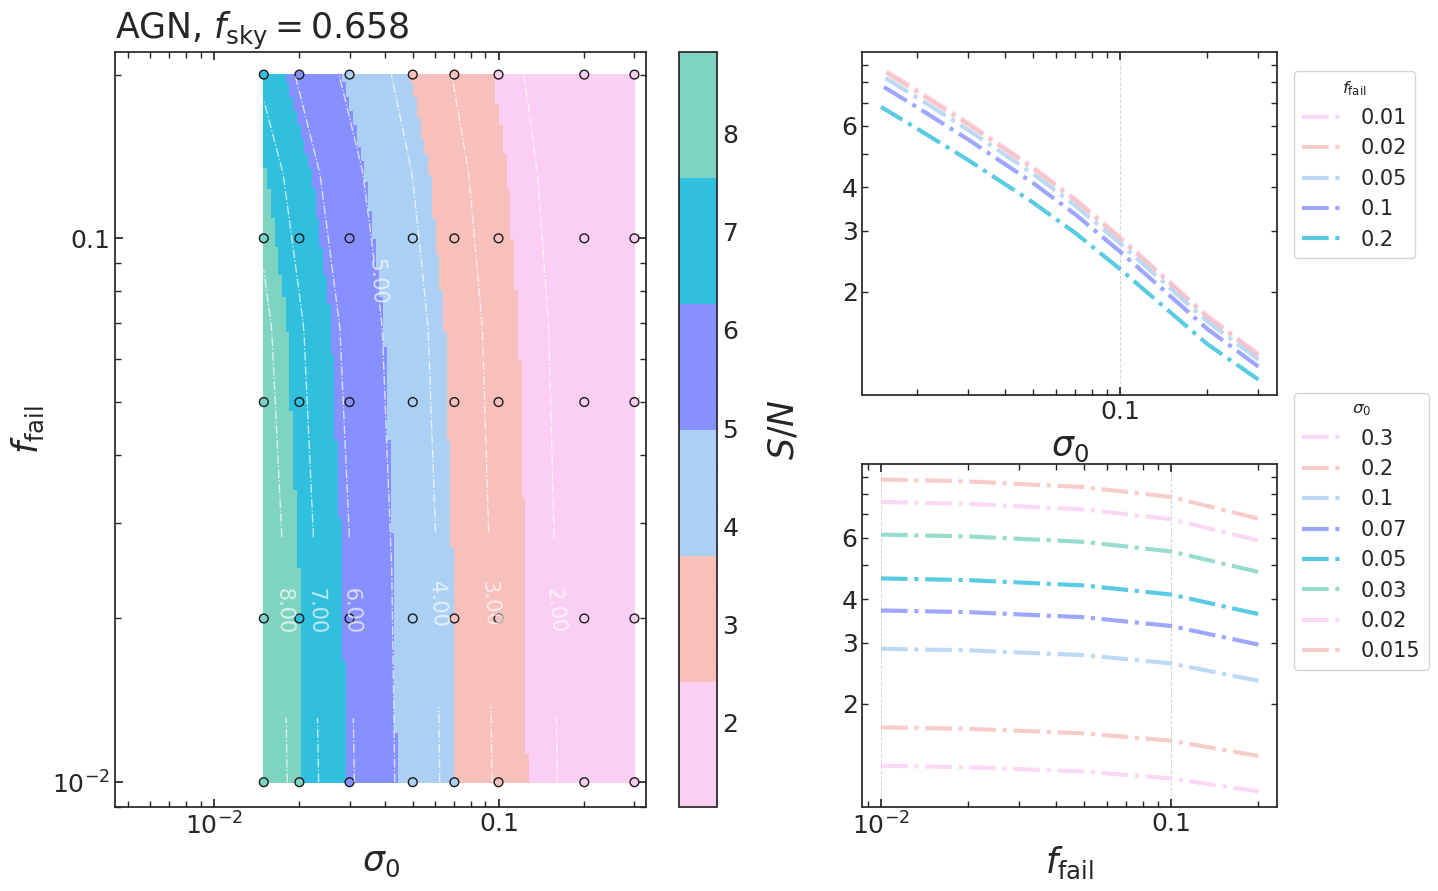

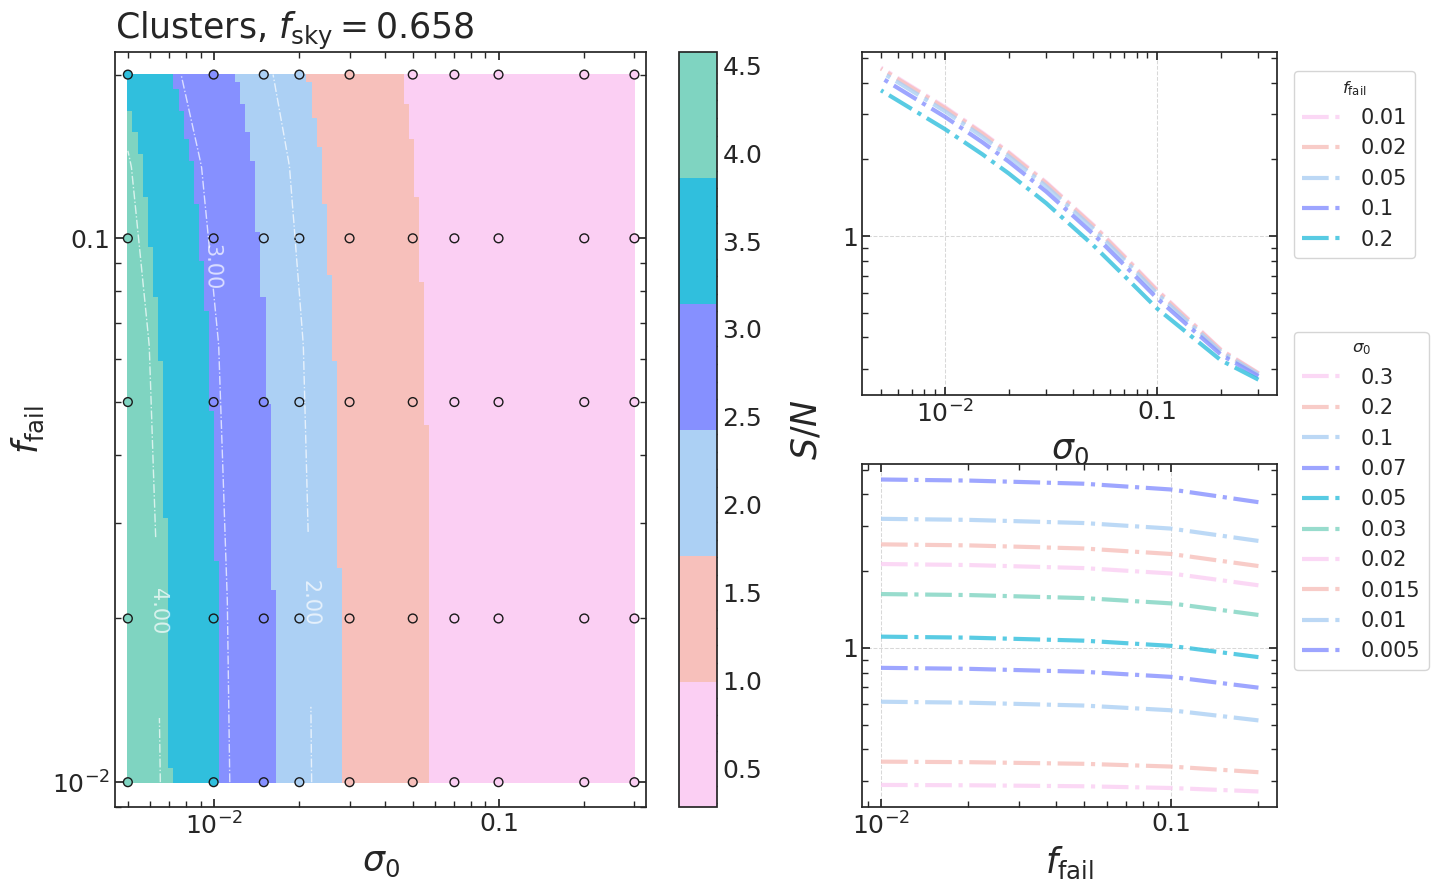

In [6]:
plot_results(type = 'AGN', interp='linear', cmap=matplotlib.colors.ListedColormap(vapeplot.palette('mallsoft')));
plt.savefig(f'{path2plots}/bao_agn.pdf')
plot_results(type = 'Clusters', interp='linear', cmap=matplotlib.colors.ListedColormap(vapeplot.palette('mallsoft')));
plt.savefig(f'{path2plots}/bao_clu.pdf')



In [8]:
# plot_results(type = 'AGN', interp='linear', cmap=matplotlib.colors.ListedColormap(vapeplot.palette('mallsoft')), fsky=0.33);
# plt.savefig(f'{path2plots}/talks/bao_agn_ru.pdf')
# plot_results(type = 'Clusters', interp='linear', cmap=matplotlib.colors.ListedColormap(vapeplot.palette('mallsoft')), fsky=0.33);
# plt.savefig(f'{path2plots}/talks/bao_clu_ru.pdf')



In [9]:
pwd

'/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-bao'

In [15]:
print(np.sqrt(np.load('data/Clusters_0.005_0.01_bao_sign.npz')['bao_sign']))
print(np.sqrt(np.load('data/old_kphotoz_clu/Clusters_0.005_0.01_bao_sign.npz')['bao_sign']))

4.575178894343465
4.524943807161573


In [17]:
print(np.sqrt(np.load('data/Clusters_0.01_0.01_bao_sign.npz')['bao_sign']))
print(np.sqrt(np.load('data/old_kphotoz_clu/Clusters_0.01_0.01_bao_sign.npz')['bao_sign']))

3.2075020337086686
3.1306491984403193


In [22]:
print(np.load('/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-cosmology/data/Clusters_0.015_0.1.npz')['F']/np.load('/Users/sdbykov/work/clustering_forecast/forecast/Fisher_matrices/impact-photoz-cosmology/data/old_kphotoz_clu/Clusters_0.015_0.1.npz')['F'])


[[1.         0.99999997 0.99999818 1.         1.00000001]
 [0.99999997 0.99999993 0.9999984  0.99999996 0.99999989]
 [0.99999818 0.9999984  0.99999635 0.99999806 0.99999681]
 [1.         0.99999996 0.99999806 1.         1.        ]
 [1.00000001 0.99999989 0.99999681 1.         1.        ]]
